### Testing notebook to prototype exposure custom options

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


## Load packages

In [3]:
# !pip install sunriset

In [4]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    # load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure, exposure1
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Temp for tide model testing 17/07/23
from dea_tools.coastal import model_tides, pixel_tides


# !pip install sunriset

## Setup
### Set analysis parameters

In [38]:
# Intertidal Elevation variables
start_date = "2021"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 300  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"  #  Tide models on Sandbox sharedrive
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
# For pandas time aliases, see: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases
modelled_freq = "30min"  # Frequency to run tidal model e.g '30T' for minutes or '1h' for hours 

# Split the number and text characters in modelled_freq
freq_time = int(re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])
freq_unit = str(re.findall(r'(\d+)(\w+)', modelled_freq)[0][-1])

# Extract the number of modelled timesteps per 14 days (half lunar cycle) for neap/spring calcs
mod_timesteps = pd.Timedelta(14,"d")/pd.Timedelta(freq_time, freq_unit)

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

In [6]:
# ##temp

# start=round_date_strings(start_date, round_type="start")
# end=round_date_strings(end_date, round_type="end")
# freq=modelled_freq
# print (start, end, freq)
# pd.date_range(start,end,freq=freq)


In [7]:
# # Set study area and config
# study_area = "gulfcarpentaria3"
# config_path = "configs/dea_intertidal_config_development.yaml"
# # study_area = '844'
# # config_path='configs/dea_intertidal_config.yaml'

#### *Optional: override study area selection using interactive map*

In [8]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow
#### Load data

In [9]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# satellite_ds = load_data(
#     dc=dc,
#     study_area=study_area,
#     time_range=(start_date, end_date),
#     resolution=resolution,
#     crs=crs,
#     s2_prod="s2_nbart_ndwi" if include_s2 else None,
#     ls_prod="ls_nbart_ndwi" if include_ls else None,
#     config_path=config_path,
#     filter_gqa=filter_gqa)[["ndwi"]]

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41919,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:46197,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/33087/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:35131,


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [10]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [11]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    # config_path=config_path,
)

2024-01-09 03:32:25 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:20<00:00,  1.67it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


2024-01-09 03:32:51 INFO Masking nodata and adding tide heights to satellite data array
2024-01-09 03:32:51 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2024-01-09 03:32:51 INFO Applying valid data mask to constrain study area
2024-01-09 03:32:51 INFO Running per-pixel rolling median


Reducing analysed pixels from 100 to 37 (37.00%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-01-09 03:32:53 INFO Modelling intertidal elevation
2024-01-09 03:32:54 INFO Modelling intertidal uncertainty
2024-01-09 03:32:54 INFO Unflattening data back to its original spatial dimensions
2024-01-09 03:32:54 INFO Cleaning inaccurate upper intertidal pixels
2024-01-09 03:32:54 INFO Successfully completed intertidal elevation modelling


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


### Intertidal extents

In [12]:
ds['extents'] = extents(
    freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr)

In [13]:
# ## Plot
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()

### Intertidal exposure
Calculate exposure using the script function

In [14]:
## Calculate exposure without the addition of any filters

ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [01:28<00:00,  2.53s/it]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs


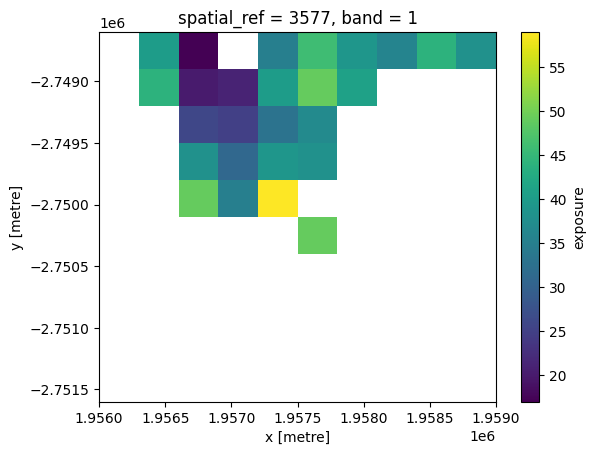

In [16]:
ds.exposure.plot()

In [58]:
## Testing exposure filtering script

%reload_ext autoreload

# Nominate which filters to use for exposure calculation
filters = ['Mar', 'Daylight']

exposure, tide_cq_summer, tiderange_summer = exposure1(
    start_date=start_date,
    end_date=end_date,
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters = filters
)

# for x in filters:
#     ds['exposure_'+str(x)]=exposure[str(x)]

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs


In [59]:
exposure

<xarray.Dataset>
Dimensions:      (y: 10, x: 10)
Coordinates:
  * y            (y) float64 -2.749e+06 -2.749e+06 ... -2.751e+06 -2.751e+06
  * x            (x) float64 1.956e+06 1.956e+06 ... 1.959e+06 1.959e+06
    spatial_ref  int32 3577
    band         int64 1
Data variables:
    Mar          (y, x) float64 nan 39.0 17.8 nan 34.6 ... nan nan nan nan nan
    Daylight     (y, x) float64 nan 39.5 16.6 nan 34.8 ... nan nan nan nan nan

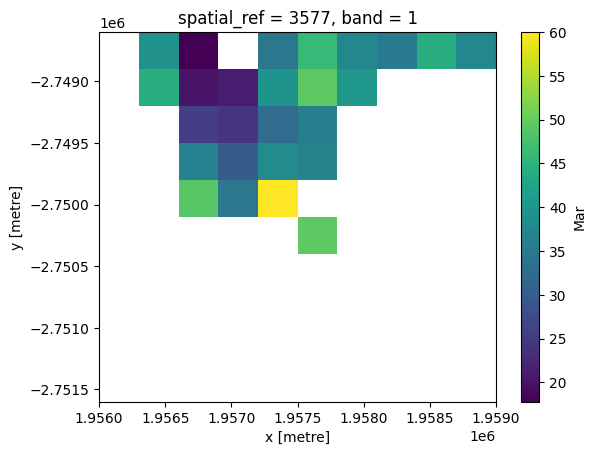

In [40]:
EXPosure.Mar.plot()

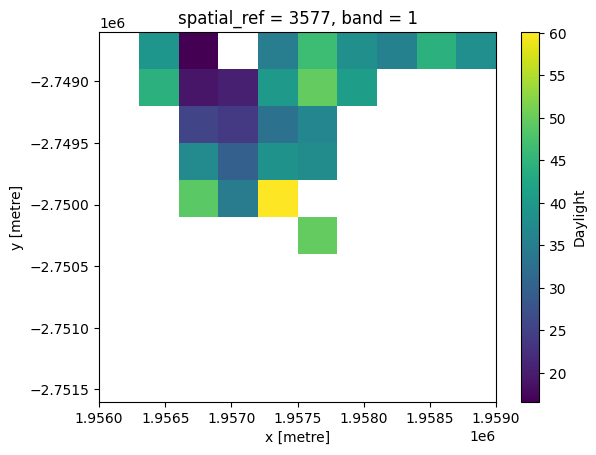

In [60]:
exposure.Daylight.plot()

In [42]:
EXPosure.Mar.all == EXPosure.Dec.all
# tide_cq_summer.Jan.isel(x=6,y=6).plot()
# tide_cq_summer.winter.isel(x=6,y=6).plot()
# EXPosure.Jan.plot()
# ds.extents.plot()

False

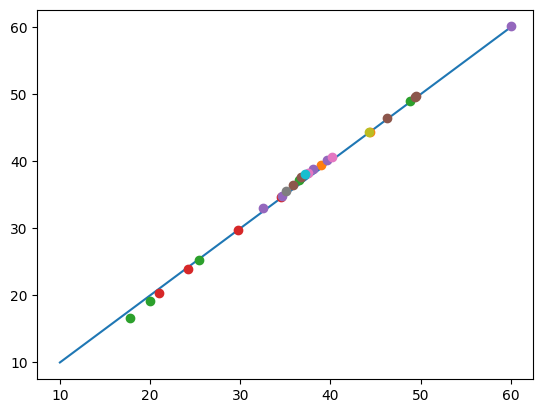

In [61]:
# plt.plot(EXPosure.winter, ds.exposure, marker='o')
plt.plot(exposure.Mar, exposure.Daylight, marker='o', linestyle=' ')
plt.plot((10,60),(10,60),zorder=0)
# plt.grid(visible=True)
# plt.figure(figsize=(6,6))

In [33]:
## View the tidal model for a given area
from intertidal.tide_modelling import pixel_tides_ensemble

tide_cq, _ = pixel_tides_ensemble(
                        ds.elevation,
                        # resample=True,
                        # calculate_quantiles=np.linspace(0, 1, 101),
                        # times=timeranges[str(x)],
                        times=all_timerange,
                        # times=time_range,
                        directory=tide_model_dir,
                        cutoff=np.inf,
                        ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
                        top_n=3,
                        reduce_method='mean',
                        resolution=3000,
                        )


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [01:46<00:00,  3.04s/it]


Returning low resolution tide array
Generating ensemble tide model from point inputs


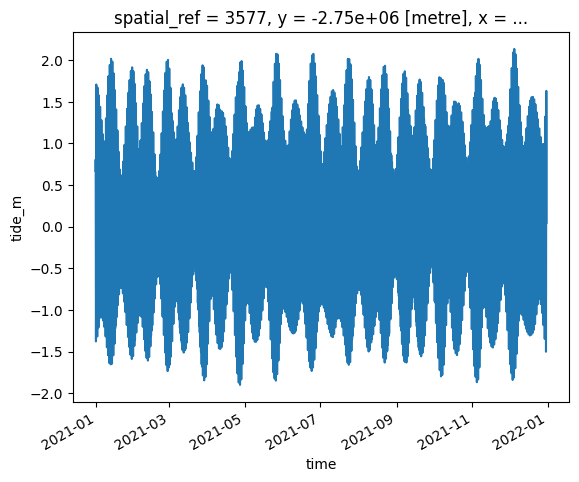

In [37]:
tide_cq[-17500:].isel(x=4,y=5).plot()

In [36]:
len(tide_cq)/7

17527.0

In [ ]:
winter_exp

In [ ]:
# timezones = {'wa':'../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp',
#                  'nt':'../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp',
#                  'sa':'../../gdata1/data/boundaries/GEODATA_COAST_100K/south_australia/cstsacd_r.shp',
#                  'qld':'../../gdata1/data/boundaries/GEODATA_COAST_100K/queensland/cstqldmd_r.shp',
#                  'nsw':'../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp',
#                  'vic':'../../gdata1/data/boundaries/GEODATA_COAST_100K/victoria/cstviccd_r.shp',
#                  'tas':'../../gdata1/data/boundaries/GEODATA_COAST_100K/tasmania/csttascd_r.shp'
#             }

In [ ]:
# ds

# Exposure

## Choose from the following 'filters' - multiple selections supported

dry, wet, summer, autumn, winter, spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, Daylight, Night, Spring_high, Spring_low, Neap_high, Neap_low, Hightide, Lowtide

In [ ]:
# %reload_ext autoreload

exposure, tide_cq, filt_dt = exposure(
                            start_date,
                            end_date,
                            dem=ds.elevation,
                            time_range=all_timerange,
                            mod_timesteps=[mod_timesteps],
                            tide_model=tide_model,
                            tide_model_dir=tide_model_dir,
                            filters = [
                                       # 'dry', 'wet', 'summer', 'autumn', 'winter', 
                                       # 'spring', 'Jan', 'Feb', 'Mar', 'Apr', 
                                       # 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 
                                       # 'Dec', 'Daylight', 'Night',
                                       'Spring_high', 'Spring_low', 'Neap_high', 'Neap_low', 
                                       'Hightide', 'Lowtide']
                            )

In [ ]:
# filt_dt.keys()

In [ ]:
plt.figure(figsize=(12,4))
filt_dt['modelledtides'][0].isel(y=1,x=1).plot()#marker='o', linestyle='')
filt_dt['springhighs_all'].isel(y=1,x=1).plot()
filt_dt['springlows_all'].isel(y=1,x=1).plot()
filt_dt['neaphighs_all'].isel(y=1,x=1).plot()
filt_dt['neaplows_all'].isel(y=1,x=1).plot()
filt_dt['hightides'].isel(y=1,x=1).plot()
filt_dt['lowtides'].isel(y=1,x=1).plot()


In [ ]:
plt.figure(figsize=(12,4))
filt_dt['modelledtides'][0][0:1500].isel(y=1,x=1).plot()#marker='o', linestyle='')
filt_dt['springhighs_all'][0:2].isel(y=1,x=1).plot()
filt_dt['springlows_all'][0:2].isel(y=1,x=1).plot()
filt_dt['neaphighs_all'][0:2].isel(y=1,x=1).plot()
filt_dt['neaplows_all'][0:2].isel(y=1,x=1).plot()
filt_dt['hightides'][0:180].isel(y=1,x=1).plot(marker='o', linestyle='')
filt_dt['lowtides'][0:180].isel(y=1,x=1).plot(marker='o', linestyle='')


## Spatial testing of peak detection on tidal modelling
[Tidal regime and ranges](http://gyre.umeoce.maine.edu/physicalocean/Tomczak/ShelfCoast/notes/figures/fig18a1.html)

|study area | tidal regime|tidal range| exposure spatial modelling behaved?|
|---|---|---|---|
|carnot WA|semi-diurnal| 4-8 m| yes|
|yawajaba WA| semi-diurnal| >8m| reasonably good. Some hightide and lowtide peaks were not captured at 3hr interval but fine at 30min|
|gulfcarpentaria3| mixed-diurnal|2-4 m||
|gulfcarpentaria1| mixed| 2-4 m||

In [ ]:
# tide_cq
exposure.hightide_exp.plot()

In [ ]:
exposure.lowtide_exp.plot()

In [ ]:
de = dry_exposure.to_dataset().rename_vars({'quantile':'dry_exposure'})
de#['quantile'].plot()#.plot()

In [ ]:
ds

In [ ]:
test = xr.merge([ds,de])
test

In [ ]:
import xarray as xr
from scipy.signal import argrelmax 
from scipy.signal import argrelmin 
from math import ceil

In [ ]:
#Run a full tidal model for each pixel
modelledtides = pixel_tides(
                            ds.elevation,#ds,
                            times=all_timerange,
                            model=tide_model,
                            directory = tide_model_dir)
## stack the y and x dimensions
stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 

In [ ]:
order=(int([mod_timesteps][0]/2))

stacked_everything_high = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))

## Unstack
springhighs_all = stacked_everything_high.unstack('z')

# order = int(ceil((len(Max_testarray.time)/(len(springhighs_all.time))/2)))
# print(springhighs_all.time)
springhighs_all

In [ ]:
# len(springhighs_all)
# print(springhighs_all.tide_m)
all_timerange

In [ ]:
print ('Calculating Spring_high')

## apply the peak detection routine
# stacked_everything_high = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))
# ## Unstack
# springhighs_all = stacked_everything_high.unstack('z')
# ##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
springhighs_all = springhighs_all.reindex(y=springhighs_all.y[::-1])
## Rename the time axis
springhighs_all = springhighs_all.rename({'dim_0':'time'})
## Convert to dataset
springhighs_all = springhighs_all.to_dataset(name = 'time')
## Reorder the dims
springhighs_all = springhighs_all[['time','y','x']]
## Select dates associated with detected peaks
springhighs_all = ModelledTides[0].to_dataset().isel(time=springhighs_all.time)
## Extract the peak height dates
# time_range = test_mt[springhighs].time.values

## Temp: for tide-regime testing
filt_dt['springhighs_all']=springhighs_all.tide_m

tide_cq = springhighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')

In [ ]:
test.dry_exposure.plot()

In [ ]:
# ds.nwet_exposure.plot()

# blank = None
# blankety = [0,1,3]

# if blank is not None:
#     print ('not none')
#     for x in blank:
#         if x in blankety:
#             if x == 1:
#                 print ('1')
# else:
#     print ('none')
np.timedelta64(14,'D') / np.timedelta64(modelled_freq.split()[0][:-1],modelled_freq.split()[0][-1])

In [ ]:
# ## Testing cell

# ## Bring in the geodata coast 100K polygons to assign local timezones to pixels

# import geopandas as gpd
# import xarray as xr

# from shapely.geometry import Point
# from shapely.ops import unary_union
# import sunriset
# from math import ceil
# import datetime
# from datetime import timedelta
# import pytz
# from pyproj import CRS
# from pyproj import Transformer

# ds.elevation.plot()

In [ ]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)

# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}")

In [ ]:
# ## Bring in the state polygons (note: native crs = epsg:4283)
# wa = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/western_australia/cstwacd_r.shp')
# nt = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp')
# sa = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/south_australia/cstsacd_r.shp')
# qld = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/queensland/cstqldmd_r.shp')
# nsw = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp')
# vic = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/victoria/cstviccd_r.shp')
# tas = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/tasmania/csttascd_r.shp')

# # Merge to create single timezone (state) boundaries
# wa = gpd.GeoSeries(unary_union(wa.geometry))
# nt = gpd.GeoSeries(unary_union(nt.geometry))
# sa = gpd.GeoSeries(unary_union(sa.geometry))
# qld = gpd.GeoSeries(unary_union(qld.geometry))
# nsw = gpd.GeoSeries(unary_union(nsw.geometry))
# vic = gpd.GeoSeries(unary_union(vic.geometry))
# tas = gpd.GeoSeries(unary_union(tas.geometry))

In [ ]:
# ## Transform the analysis aoi coords to common CRS

# tidepost_lat_3577 = ds.x.median(dim='x').values
# tidepost_lon_3577 = ds.y.median(dim='y').values

# ## Datacube native CRS
# crs_3577 = CRS.from_epsg(3577) 

# ## GDA94/Aus Albers (meters)

# ## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library

# ## World WGS84 (degrees)
# crs_4326 = CRS.from_epsg(4326) 
# ## Transfer coords from/to
# transformer_4326 = Transformer.from_crs(crs_3577, crs_4326)
# ## Translate the tidepost coords
# tidepost_lat_4326, tidepost_lon_4326 = transformer_4326.transform(tidepost_lat_3577, tidepost_lon_3577)
# ## Coordinate point to locate the sunriset calculation
# point_4326 = Point(tidepost_lon_4326, tidepost_lat_4326)

# ## (1) Create a transform to convert default epsg3577 coords to epsg4283 to compare against polygons and 
# ## assign a timezone

# ## GDA94 CRS (degrees)
# crs_4283 = CRS.from_epsg(4283) ## GDA94 Australia (degrees)
# ## Transfer coords from/to
# transformer_4283 = Transformer.from_crs(crs_3577, crs_4283) 
# ## Translate tidepost coords
# tidepost_lat_4283, tidepost_lon_4283 = transformer_4283.transform(tidepost_lat_3577, tidepost_lon_3577)
# ## Coordinate point to test for timezone   
# point_4283 = Point(tidepost_lon_4283, tidepost_lat_4283)


In [ ]:
# ## Set the local timezone for the analysis area of interest
# if wa.contains(point_4283)[0] == True:
#     timezone = 'Australia/West'
#     local_tz = 8
#     # break
# elif nt.contains(point_4283)[0] == True:
#     timezone = 'Australia/North'
#     local_tz = 9.5
#     # break
# elif sa.contains(point_4283)[0] == True:
#     timezone = 'Australia/South'
#     local_tz = 9.5
#     # break
# elif qld.contains(point_4283)[0] == True:
#     timezone = 'Australia/Queensland'
#     local_tz = 10
#     # break
# elif nsw.contains(point_4283)[0] == True:
#     timezone = 'Australia/NSW'
#     local_tz = 10
#     # break
# elif vic.contains(point_4283)[0] == True:
#     timezone = 'Australia/Victoria'
#     local_tz = 10
#     # break
# elif tas.contains(point_4283)[0] == True:
#     timezone = 'Australia/Tasmania'
#     local_tz = 10
#     # break
# print (timezone, local_tz)    

In [ ]:
# ## Testing sunriset calculations

# # Place start and end dates in correct format
# start=round_date_strings(start_date, round_type="start")
# end=round_date_strings(end_date, round_type="end")
# startdate = datetime.date(pd.to_datetime(start).year, pd.to_datetime(start).month, pd.to_datetime(start).day)

# # # Make the start date timezone aware 
# # time_start = pd.to_datetime(start, utc=True).tz_convert(timezone)

# # Make 'all_timerange' time-zone aware
# localtides = all_timerange.tz_localize(tz=pytz.UTC).tz_convert(timezone)

# # Replace the UTC datetimes from all_timerange with local times
# modelledtides = pd.DataFrame(index = localtides)

# # Return the difference in years for the time-period. 
# # Round up to ensure all modelledtide datetimes are captured in the solar model
# diff = pd.to_datetime(end) - pd.to_datetime(start)
# diff = int(ceil(diff.days/365))

# # ## Locate the central pixel for the area of interest
# # ## TODO: work out how to manage this in the pixel-based workflow. Perhaps
# # ## use the same modelling resolution as the underlying tidal model?
# # tidepost_lat = ds.x.median(dim='x')
# # tidepost_lon = ds.y.median(dim='y')

# # ## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library
# # crs_4326 = CRS.from_epsg(4326)
# # crs_3577 = CRS.from_epsg(3577)

# # transformer = Transformer.from_crs(crs_3577, crs_4326)

# # ## Translate tidepost coords
# # tidepost_lat, tidepost_lon = transformer.transform(tidepost_lon.values, tidepost_lat.values)

# ## Model sunrise and sunset
# sun_df = sunriset.to_pandas(startdate, tidepost_lat_4326, tidepost_lon_4326, local_tz, diff)

# ## Set the index as a datetimeindex to match the modelledtide df
# sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))

# ## Append the date to each Sunrise and Sunset time
# sun_df['Sunrise dt'] = sun_df.index + sun_df['Sunrise']
# sun_df['Sunset dt'] = sun_df.index + (sun_df['Sunset'])

# ## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
# daytime=pd.DataFrame(data = 'Sunrise', index=sun_df['Sunrise dt'], columns=['Sunlight'])
# nighttime=pd.DataFrame(data = 'Sunset', index=sun_df['Sunset dt'], columns=['Sunlight'])
# DayNight = pd.concat([daytime, nighttime], join='outer')
# DayNight.sort_index(inplace=True)
# DayNight.index.rename('Datetime', inplace=True)

# ## Create an xarray object from the merged day/night dataframe
# day_night = xr.Dataset.from_dataframe(DayNight)

# ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
# ## timezone aware datetimeindexes 'from_dataframe' very well.
# modelledtides.index = modelledtides.index.tz_localize(tz=None)

# ## Create an xr Dataset from the modelledtides pd.dataframe
# mt = modelledtides.to_xarray()

# ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
# ## Modelled tides are designated as either day or night by propogation of the last valid index value forward
# Solar=day_night.sel(Datetime=mt.index, method='ffill')

# ## Assign the day and night tideheight datasets
# SolarDayTides = mt.where(Solar.Sunlight=='Sunrise', drop=True)
# SolarNightTides = mt.where(Solar.Sunlight=='Sunset', drop=True)

# ## Extract DatetimeIndexes to use in exposure calculations
# all_timerange_day = pd.DatetimeIndex(SolarDayTides.index)
# all_timerange_night = pd.DatetimeIndex(SolarNightTides.index)



In [ ]:
ds.exposure_daylight.plot()

In [ ]:
ds.elevation.plot()

In [ ]:
from dea_tools.coastal import model_tides, pixel_tides

from scipy.signal import argrelmax 
from scipy.signal import argrelmin 
from scipy.interpolate import interp1d 
import xarray as xr

from math import ceil

## filters can be any of
Spring_high, Spring_low, Neap_high, Neap_low, Hightide, Lowtide

In [ ]:
## Testing for spatial customisation (splicing up the tidal zone)

modelledtides = pixel_tides(
                ds,
                times=all_timerange,
                model=tide_model,
                directory = tide_model_dir)
                # directory = '../../gdata1/data/tide_models')
    

In [ ]:
# ds
type(modelled_freq)

In [ ]:
## Peak selections in xarray for whole arrays
## Calculations for Spring/Neap/High/Low tides
## Hardcoded assumption: one spring high tide per 14 day half-lunar cycle
test_filters = ['Lowtide', 'Hightide']#'Spring_low', 'Neap_low']#'Lowtide','Spring_high','Hightide','Neap_high'] # 'Spring_high' must run by default as its outputs are required for neap tide detection
# Extract the modelling freq units
freq_unit = modelled_freq.split()[0][-1]
freq_value = modelled_freq.split()[0][:-1]
# Extract the number of modelled timesteps per 14 days
mod_timesteps = np.timedelta64(14,'D') / np.timedelta64(freq_value,freq_unit)
## Identify kwargs for peak detection algorithm
order=(int(mod_timesteps/2))

## stack the y and x dimensions
stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 

## Calculate the spring highest and spring lowest tides per 14 day half lunar cycle
if 'Spring_high' in test_filters:
    # ## stack the y and x dimensions
    # stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine
    stacked_everything = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))
    ## Unstack
    springhighs_all = stacked_everything.unstack('z')
    ##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
    springhighs_all = springhighs_all.reindex(y=springhighs_all.y[::-1])
    ## Rename the time axis
    springhighs_all = springhighs_all.rename({'dim_0':'time'})
    ## Convert to dataset
    springhighs_all = springhighs_all.to_dataset(name = 'time')
    ## Reorder the dims
    springhighs_all = springhighs_all[['time','y','x']]
    ## Select dates associated with detected peaks
    springhighs_all = modelledtides[0].to_dataset().isel(time=springhighs_all.time)
    ## Extract the peak height dates
    # time_range = test_mt[springhighs].time.values

    ## Calculate the spring highest and spring lowest tides per 14 day half lunar cycle
if 'Spring_low' in test_filters:
    ## apply the peak detection routine
    stacked_everything = stacked_everything.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order)[0]))
    ## Unstack
    springlows_all = stacked_everything.unstack('z')
    ##Reorder the y axis. Uncertain why it gets reversed during the stack/unstack.
    springlows_all = springlows_all.reindex(y=springlows_all.y[::-1])
    ## Rename the time axis
    springlows_all = springlows_all.rename({'dim_0':'time'})
    ## Convert to dataset
    springlows_all = springlows_all.to_dataset(name = 'time')
    ## Reorder the dims
    springlows_all = springlows_all[['time','y','x']]
    ## Select dates associated with detected peaks
    springlows_all = modelledtides[0].to_dataset().isel(time=springlows_all.time)
    ## Extract the peak height dates
    # time_range = test_mt[springlows_all].time.values
    
if 'Neap_high' in test_filters:
    # ## stack the y and x dimensions
    # stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    Max_testarray = modelledtides[0].to_dataset().isel(time=Max_testarray.time)
    
    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
    ## relative to the number of spring high tide values
    order = int(ceil((len(Max_testarray.time)/(len(springhighs_all.time))/2)))
    ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
    neaphighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order)[0]))
    ## unstack and format as above                                    
    neaphighs_all = neaphighs_all.unstack('z')
    neaphighs_all = (
                    neaphighs_all
                     .reindex(y=neaphighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract neap high tides
    neaphighs_all = Max_testarray.isel(time=neaphighs_all.time)
    
if 'Neap_low' in test_filters:
    # ## stack the y and x dimensions
    # stacked_everything = modelledtides[0].stack(z=['y','x']).groupby('z') 
    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    Max_testarray = modelledtides[0].to_dataset().isel(time=Max_testarray.time)
    
    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
    ## relative to the number of spring high tide values
    order = int(ceil((len(Max_testarray.time)/(len(springhighs_all.time))/2)))
    ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
    neaphighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order)[0]))
    ## unstack and format as above                                    
    neaphighs_all = neaphighs_all.unstack('z')
    neaphighs_all = (
                    neaphighs_all
                     .reindex(y=neaphighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract neap high tides
    neaphighs_all = Max_testarray.isel(time=neaphighs_all.time)
    
if 'Hightide' in test_filters:
    def lowesthightides(x):
        '''
        x is a grouping of x and y pixels from the peaks_array (labelled as 'z')
        '''

        ## apply the peak detection routine to calculate all the high tide maxima
        high_peaks = np.array(argrelmax(x.values)[0])

        ## extract all hightide peaks
        Max_testarray = x.isel(time=high_peaks)

        ## Identify all lower hightide peaks
        lowhigh_peaks = np.array(argrelmin(Max_testarray.values)[0])

        ## Interpolate the lower hightide curve
        neap_high_linear = interp1d(
                                    ## low high peaks as a subset of all high tide peaks
                                    high_peaks[lowhigh_peaks],
                                    ## Corresponding tide heights
                                    Max_testarray.isel(time=lowhigh_peaks).squeeze(['z']).values,
                                    kind='linear', 
                                    fill_value='extrapolate'
                                    )
        ## Create an array to interpolate into sans datetimes
        count = np.arange(0,len(x),1)
        neap_high_testline = neap_high_linear(count)

        # # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
        hightide = x.squeeze(['z']).where(x.squeeze(['z']) >= neap_high_testline, drop=True)

        return hightide 

    ## Vectorise the hightide calculation
    lowhighs_all = stacked_everything.apply(lambda x: xr.DataArray(lowesthightides(x)))

    # ## Unstack and re-format the array
    lowhighs_all = lowhighs_all.unstack('z')
    lowhighs_all_unstacked = (
                        lowhighs_all
                         .reindex(y=lowhighs_all.y[::-1])
                         # .rename({'dim_0':'time'})
                         # .rename({'time':'hightide'})
                         .to_dataset()#name = 'time')
                         [['tide_m','time','y','x']]
                        )

    ## Calculate exposure using regular method
    calculate_quantiles = np.linspace(0, 1, 101)#101)

    tide_cq = lowhighs_all_unstacked.tide_m.quantile(q=calculate_quantiles,dim='time')

    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(tide_cq - ds.elevation)

    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")

    # Convert to percentage
    hightide_exposure = idxmin * 100
    
    # return hightide_exposure

if 'Lowtide' in test_filters:
    def highestlowtides(x):
        '''
        x is a grouping of x and y pixels from the peaks_array (labelled as 'z')
        '''

        ## apply the peak detection routine to calculate all the high tide maxima
        low_peaks = np.array(argrelmin(x.values)[0])

        ## extract all hightide peaks
        Min_testarray = x.isel(time=low_peaks)

        ## Identify all lower hightide peaks
        highlow_peaks = np.array(argrelmax(Min_testarray.values)[0])

        ## Interpolate the lower hightide curve
        neap_low_linear = interp1d(
                                ## low high peaks as a subset of all high tide peaks
                                low_peaks[highlow_peaks],
                                ## Corresponding tide heights
                                Min_testarray.isel(time=highlow_peaks).squeeze(['z']).values,
                                # stacked_everything33, 
                                # stacked_everything333.isel(y=0,x=0), # z=0 in stacked arrays?
                                # stacked_everything333,#.isel(z=x), # z=0 in stacked arrays?
                                # stacked_everything333.squeeze(['z']).values,
                                bounds_error=False, 
                                kind='linear', 
                                fill_value='extrapolate'
                              )
        ## Create an array to interpolate into sans datetimes
        count = np.arange(0,len(x),1)
        neap_low_testline = neap_low_linear(count)

        # # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
        lowtide = x.squeeze(['z']).where(x.squeeze(['z']) >= neap_low_testline, drop=True)

        return lowtide 

    ## Vectorise the hightide calculation
    highlows_all = stacked_everything.apply(lambda x: xr.DataArray(highestlowtides(x)))

    # ## Unstack and re-format the array
    highlows_all = highlows_all.unstack('z')
    highlows_all_unstacked = (
                        highlows_all
                         .reindex(y=highlows_all.y[::-1])
                         # .rename({'dim_0':'time'})
                         # .rename({'time':'hightide'})
                         .to_dataset()#name = 'time')
                         [['tide_m','time','y','x']]
                        )

    ## Calculate exposure using regular method
    calculate_quantiles = np.linspace(0, 1, 101)#101)

    tide_cq = highlows_all_unstacked.tide_m.quantile(q=calculate_quantiles,dim='time')

    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(tide_cq - ds.elevation)

    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")

    # Convert to percentage
    lowtide_exposure = idxmin * 100

    # return lowtide_exposure

In [ ]:
# ## Peak selections in xarray for single pixel
# ## Calculations for Spring/Neap/High/Low tides
# ## Hardcoded assumption: one spring high tide per 14 day half-lunar cycle

# # Extract the modelling freq units
# freq_unit = modelled_freq.split()[0][-1]
# freq_value = modelled_freq.split()[0][:-1]
# # Extract the number of modelled timesteps per 14 days
# mod_timesteps = np.timedelta64(14,'D') / np.timedelta64(freq_value,freq_unit)

# # Modelledtides for pixel y1x1
# test_mt = modelledtides[0].isel(y=1,x=1)

# ## Calculate the (spring) highest and lowest tides per 14 day half lunar cycle
# springhighs = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values,
#                                 order=(int(mod_timesteps/2)))[0])
# springlows = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values,
#                                 order=(int(mod_timesteps/2)))[0])

# ## Calculate the neap high and low tides per 14 day half lunar cycle
# # Calculate all the high tide maxima
# Max_test = np.array(argrelmax(modelledtides[0].isel(y=1,x=1).values)[0])
# # Calculate the neap high tide minima per half lunar cycle, based on the number of spring high maxima
# neaphighs = np.array(argrelmin(test_mt[Max_test].values,
#                               order=(int(ceil((len(test_mt[Max_test])/len(springhighs))/2))))[0])
# # Calculate all the low tide minima
# Min_test = np.array(argrelmin(modelledtides[0].isel(y=1,x=1).values)[0])
# # Calculate the neap low tide maxima per half lunar cycle, based on the number of spring low minima
# neaplows = np.array(argrelmax(test_mt[Min_test].values,
#                               order=(int(ceil((len(test_mt[Min_test])/len(springlows))/2))))[0])

# # if 'Spring_high':
# #     time_range = test_mt[springhighs].time.values
# # if 'Spring_low':
# #     time_range = test_mt[springlows].time.values
# # if 'Neap_high':
# #     time_range = test_mt[Max_test][neaphighs].time.values
# # if 'Neap_low':
# #     time_range = test_mt[Min_test][neaplows].time.values

# ## Calculate all hightide and lowtide peaks

# # Create a dataset to model into, same length as test_mt (modelledtides) but without 
# # the complication of datetimes
# count = np.arange(0,len(test_mt),1)

# ## Need to extract the maxima and minima from the high and low tide maxima respectively
# Max_max = np.array(argrelmax(test_mt[Max_test].values)[0])
# Max_min = np.array(argrelmin(test_mt[Max_test].values)[0])

# Min_max = np.array(argrelmax(test_mt[Min_test].values)[0])
# Min_min = np.array(argrelmin(test_mt[Min_test].values)[0])


# ## Interpolate the high and low spring and neap curves
# # neap high tide curve
# neap_high_linear = interp1d(Max_test[Max_min], 
#                             test_mt[Max_test][Max_min].values, 
#                             bounds_error=False, 
#                             kind='linear', 
#                             fill_value='extrapolate'
#                            )
# neap_high_testline = neap_high_linear(count)
# # # spring high tide curve
# # spring_high_linear = interp1d(Max_test[Max_max], 
# #                               test_mt[Max_test][Max_max].values, 
# #                               bounds_error=False, 
# #                               kind='linear', 
# #                               fill_value='extrapolate'
# #                              )
# # spring_high_testline = spring_high_linear(count)
# # neap low tide curve
# neap_low_linear = interp1d(Min_test[Min_max], 
#                            test_mt[Min_test][Min_max].values, 
#                            bounds_error=False, 
#                            kind='linear', 
#                            fill_value='extrapolate')
# neap_low_testline = neap_low_linear(count)
# # # spring low tide curve
# # spring_low_linear = interp1d(Min_test[Min_min], 
# #                              test_mt[Min_test][Min_min].values, 
# #                              bounds_error=False, 
# #                              kind='linear', 
# #                              fill_value='extrapolate')
# # spring_low_testline = spring_low_linear(count)
# # turn test_mt (modelledtides) into xr.Dataset
# test_mt = test_mt.to_dataset()
# # append the extrapolated tidelines for the lowest high tides and
# # highest low tides (not really neap - more neap-esque)
# test_mt['neap_high_testline'] = (('time'), neap_high_testline)
# test_mt['neap_low_testline'] = (('time'), neap_low_testline)
# # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
# hightide = test_mt['tide_m'].where(test_mt['tide_m'] >= test_mt['neap_high_testline'], drop=True)
# # Extract lowtides as all tides lower than/equal to the extrapolated highest low tide line
# lowtide = test_mt['tide_m'].where(test_mt['tide_m'] <= test_mt['neap_low_testline'], drop=True)
# # Extract datetimes to run through exposure module
# # if 'Hightide':
# #     time_range = hightide.time.values
# # if 'Lowtide':
# #     time_range = lowtide.time.values

In [ ]:
# all_timerange

# dry =  all_timerange.drop(all_timerange
#                         [(all_timerange.month == 10) ## Wet season: Oct-Mar
#                         |(all_timerange.month == 11)
#                         |(all_timerange.month == 12)
#                         |(all_timerange.month == 1)
#                         |(all_timerange.month == 2)
#                         |(all_timerange.month == 3)
#                         ])

# wet = all_timerange.drop(all_timerange
#                         [(all_timerange.month == 4) ## Dry season: Apr-Sep
#                         |(all_timerange.month == 5)
#                         |(all_timerange.month == 6)
#                         |(all_timerange.month == 7)
#                         |(all_timerange.month == 8)
#                         |(all_timerange.month == 9)
#                         ])


# dry_modelledtides = pixel_tides(
#                     ds,
#                     times=dry,
#                     model=tide_model,
#                     directory = tide_model_dir)

# wet_modelledtides = pixel_tides(
#                     ds,
#                     times=wet,
#                     model=tide_model,
#                     directory = tide_model_dir)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
modelledtides[0].isel(y=1,x=1).where(modelledtides[0].isel(y=1,x=1).time != 

In [ ]:
dry_modelledtides[0].isel(y=1,x=1).plot(zorder=0)#marker='.', linestyle='')
wet_modelledtides[0].isel(y=1,x=1).plot(marker='', linestyle='')

# modelledtides.isel(y=1,x=1).where(modelledtides.isel(y=1,x=1) != 

In [ ]:
plt.rcParams['font.size']=16

test_mt.tide_m[0:-1].plot(zorder=1, label='wet season', color='#1f77b4', figsize=(9, 5),)#, marker='.', linestyle='')

dry_modelledtides[0][0:1464].isel(y=1,x=1).plot( label='all tides', color='#ff7f0e')#, marker='.', linestyle='')
dry_modelledtides[0][1465:2928].isel(y=1,x=1).plot(color='#ff7f0e')#figsize=(9, 5), label='dry season')#, marker='.', linestyle='')
dry_modelledtides[0][2929:].isel(y=1,x=1).plot(color='#ff7f0e')#figsize=(9, 5), label='dry season')#, marker='.', linestyle='')
# wet_modelledtides[0].isel(y=1,x=1).plot(marker='', linestyle='')


## Plots to check outputs of high and low tide selections
# lowtide[0:-1].plot(zorder=2, figsize=(9, 5), label='lowtide')#, marker='.', linestyle='')
# lowtide[0:-1].plot(zorder=3, marker='.', linestyle='')

# test_mt.neap_high_testline[0:-1].plot()
# test_mt.neap_low_testline[0:2000].plot(zorder=10)
plt.title('')
plt.legend(loc='lower right')
plt.xticks(ticks=[])
# plt.margins(0)

plt.savefig(f"{output_dir}/{study_area}_{start_date}_{end_date}_px_wetseason", bbox_inches='tight')

In [ ]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [ ]:
# Plots to check outputs of spring and neap tides selections

# BEWARE: if this cell isn't working, check test_mt as it was prototyped as an 
# xr.Dataarray but was later converted to xr.Dataset

test_mt.tide_m[1280:1485].plot(zorder=0)#ylim=0) #Modelledtides
test_mt.tide_m[Max_test][310:357].plot(marker='o', linestyle='')
test_mt.tide_m[Min_test][310:357].plot(marker='o', linestyle='', zorder=1)

test_mt.tide_m[springhighs][11:13].plot(marker='o', linestyle='') 
test_mt.tide_m[springlows][11:13].plot(marker='o', linestyle='', zorder=2) 
test_mt.tide_m[Max_test][neaphighs][11:13].plot(marker='o', linestyle='')
test_mt.tide_m[Min_test][neaplows][11:13].plot(marker='o', linestyle='', zorder=100)

plt.plot(test_mt.tide_m[1280:1470].time, neap_high_testline[1280:1470])
plt.plot(test_mt.tide_m[1280:1470].time, spring_high_testline[1280:1470])
plt.plot(test_mt.tide_m[1280:1470].time, neap_low_testline[1280:1470])
plt.plot(test_mt.tide_m[1280:1470].time, spring_low_testline[1280:1470])


In [ ]:
ds['lowtide_exposure'] = lowtide_exposure#.plot()

In [ ]:
ds['hightide_exposure'] = hightide_exposure#.plot()

In [ ]:
tiderange_day == tiderange_night

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}")
# Save rasters as GeoTIFFs
# export_intertidal_rasters(hightide_exposure, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}")

In [ ]:
ds